# The QIF Mean-Field Model

An exact mean-field reduction of spiking neural populations using the Montbrio-Pazo-Roxin framework.

## Learning Objectives

By the end of this tutorial, you will be able to:

- Understand the QIF mean-field reduction and why it's exact
- Explain the role of the Lorentzian distribution of excitabilities
- Simulate population firing rate and mean membrane potential dynamics
- Analyze bifurcations in the QIF model as a function of external input

## Prerequisites

- **Tutorial 000**: Getting Started with BrainMass
- **Tutorial 020**: Wilson-Cowan model (E/I population concepts)
- Basic understanding of neural firing rates

## Background / Theory

### From Spiking Neurons to Mean Fields

Most neural mass models (Wilson-Cowan, Jansen-Rit) are phenomenological - they capture qualitative features but aren't derived from spiking neuron dynamics.

The **Quadratic Integrate-and-Fire (QIF)** mean-field model is different: it's an **exact** reduction of a population of QIF neurons with heterogeneous excitabilities.

### The Montbrio-Pazo-Roxin Reduction

Consider $N$ all-to-all coupled QIF neurons:

$$
\tau \dot{V}_j = V_j^2 + \eta_j + I(t) + J\tau r(t)
$$

where $\eta_j$ is drawn from a Lorentzian distribution with mean $\bar{\eta}$ and width $\Delta$.

Remarkably, in the limit $N \to \infty$, this reduces exactly to:

$$
\begin{aligned}
\tau\dot{r} &= \frac{\Delta}{\pi} + 2\tau r v \\
\tau\dot{v} &= v^2 + \bar{\eta} + I(t) + J\tau r - (\pi\tau r)^2
\end{aligned}
$$

where:
- $r$: Population firing rate
- $v$: Mean membrane potential

### Key Parameters

| Parameter | Symbol | Description |
|-----------|--------|-------------|
| Time constant | $\tau$ | Membrane time constant |
| Mean excitability | $\bar{\eta}$ | Center of Lorentzian distribution |
| Heterogeneity | $\Delta$ | Width of Lorentzian (HWHM) |
| Coupling | $J$ | Recurrent synaptic strength |

### Why Is This Important?

1. **Exact reduction**: No approximations needed (unlike firing rate models)
2. **Captures heterogeneity**: The $\Delta$ parameter models neuron-to-neuron variability
3. **Biophysically grounded**: Directly relates to spiking neuron properties
4. **Low-dimensional**: Only 2 variables describe the entire population

## Implementation

### Step 1: Setup and Imports

In [1]:
import brainstate
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

import brainmass

# Set simulation time step
brainstate.environ.set(dt=0.01 * u.ms)  # Fine timestep for accuracy

### Step 2: Single Population Simulation

Create a QIF population and observe its dynamics:

In [2]:
# Create QIF model
model = brainmass.MontbrioPazoRoxinStep(
    in_size=1,  # single population
    tau=1.0 * u.ms,  # time constant
    eta=-5.0,  # mean excitability (negative = subthreshold)
    delta=1.0 * u.Hz,  # heterogeneity (Lorentzian width)
    J=15.0,  # recurrent coupling strength
)

# Initialize states
brainstate.nn.init_all_states(model)

# Set non-zero initial firing rate
model.r.value = np.array([0.1]) * u.Hz
model.v.value = np.array([-2.0])

print(f"tau = {model.tau.value()}")
print(f"eta = {model.eta.value()}")
print(f"delta = {model.delta.value()}")
print(f"J = {model.J.value()}")

tau = 1.0 * msecond
eta = -5.0
delta = 1.0 * hertz
J = 15.0


In [3]:
# Define simulation step
def step_run(i):
    with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
        r = model.update()
        return model.r.value, model.v.value


# Run simulation (100 ms)
n_steps = int(100 * u.ms / brainstate.environ.get_dt())
indices = np.arange(n_steps)
r_trace, v_trace = brainstate.transform.for_loop(step_run, indices)

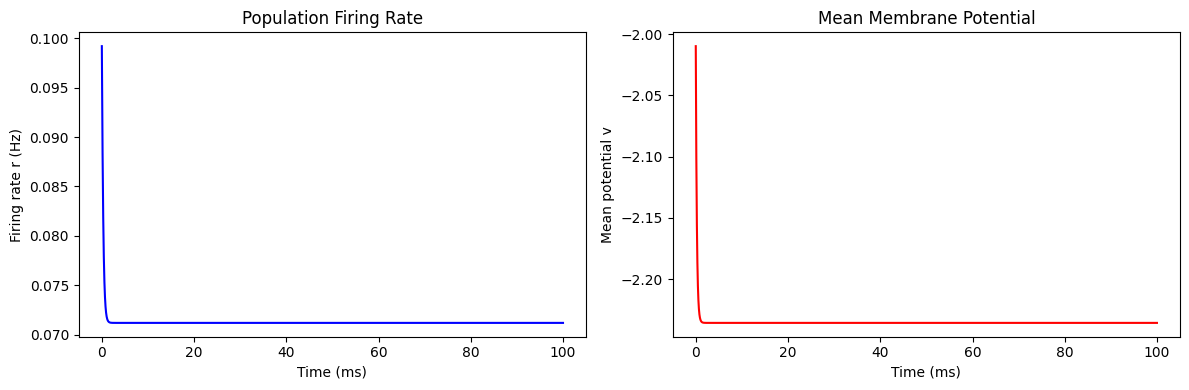

In [4]:
t_ms = indices * brainstate.environ.get_dt()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Firing rate
axes[0].plot(t_ms, r_trace[:, 0], 'b-', linewidth=1.5)
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Firing rate r (Hz)')
axes[0].set_title('Population Firing Rate')

# Mean membrane potential
axes[1].plot(t_ms, v_trace[:, 0], 'r-', linewidth=1.5)
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Mean potential v')
axes[1].set_title('Mean Membrane Potential')

plt.tight_layout()
plt.show()

### Step 3: Phase Portrait

The (r, v) phase space reveals the attractor structure:

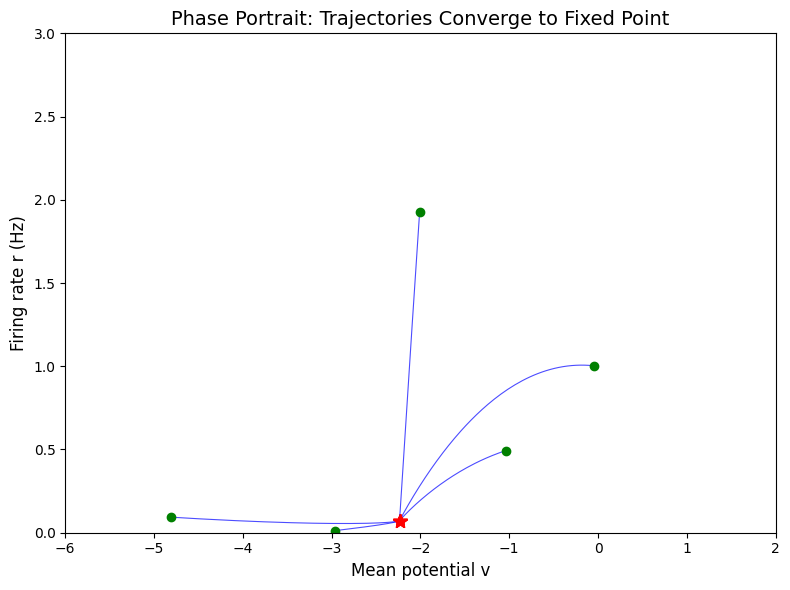

In [5]:
# Run multiple trajectories with different initial conditions
fig, ax = plt.subplots(figsize=(8, 6))

init_conditions = [
    (0.01, -3.0),
    (0.5, -1.0),
    (1.0, 0.0),
    (0.1, -5.0),
    (2.0, -2.0),
]

for r0, v0 in init_conditions:
    model = brainmass.MontbrioPazoRoxinStep(in_size=1, tau=1.0 * u.ms, eta=-5.0, delta=1.0 * u.Hz, J=15.0)
    brainstate.nn.init_all_states(model)
    model.r.value = np.array([r0]) * u.Hz
    model.v.value = np.array([v0])


    def step(i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            model.update()
            return model.r.value, model.v.value


    r, v = brainstate.transform.for_loop(step, np.arange(int(50 * u.ms / brainstate.environ.get_dt())))

    ax.plot(v[:, 0], r[:, 0], 'b-', linewidth=0.8, alpha=0.7)
    ax.plot(v[0, 0], float(r[0, 0] / u.Hz), 'go', markersize=6)
    ax.plot(v[-1, 0], float(r[-1, 0] / u.Hz), 'r*', markersize=10)

ax.set_xlabel('Mean potential v', fontsize=12)
ax.set_ylabel('Firing rate r (Hz)', fontsize=12)
ax.set_title('Phase Portrait: Trajectories Converge to Fixed Point', fontsize=14)
ax.set_xlim([-6, 2])
ax.set_ylim([0, 3])
plt.tight_layout()
plt.show()

### Step 4: Response to External Input

The QIF model responds to external input $I(t)$:

In [7]:
# Create model with noise for realism
model = brainmass.MontbrioPazoRoxinStep(
    in_size=1,
    tau=1.0 * u.ms,
    eta=-5.0,
    delta=1.0 * u.Hz,
    J=15.0,
    noise_r=brainmass.OUProcess(1, sigma=0.1 * u.Hz, tau=1.0 * u.ms),
)
model.init_all_states()


# External input: step function
def get_input(t):
    """Step input at t=50ms"""
    return u.math.where(t > 50. * u.ms, 5.0, 0.0)


def step_run(i):
    t = i * brainstate.environ.get_dt()
    v_inp = get_input(t)
    with brainstate.environ.context(i=i, t=t):
        model.update(v_inp=v_inp)
        return model.r.value, model.v.value


# Simulate
n_steps = int(150 * u.ms / brainstate.environ.get_dt())
r_trace, v_trace = brainstate.transform.for_loop(step_run, np.arange(n_steps))
t_ms = np.arange(n_steps) * brainstate.environ.get_dt()

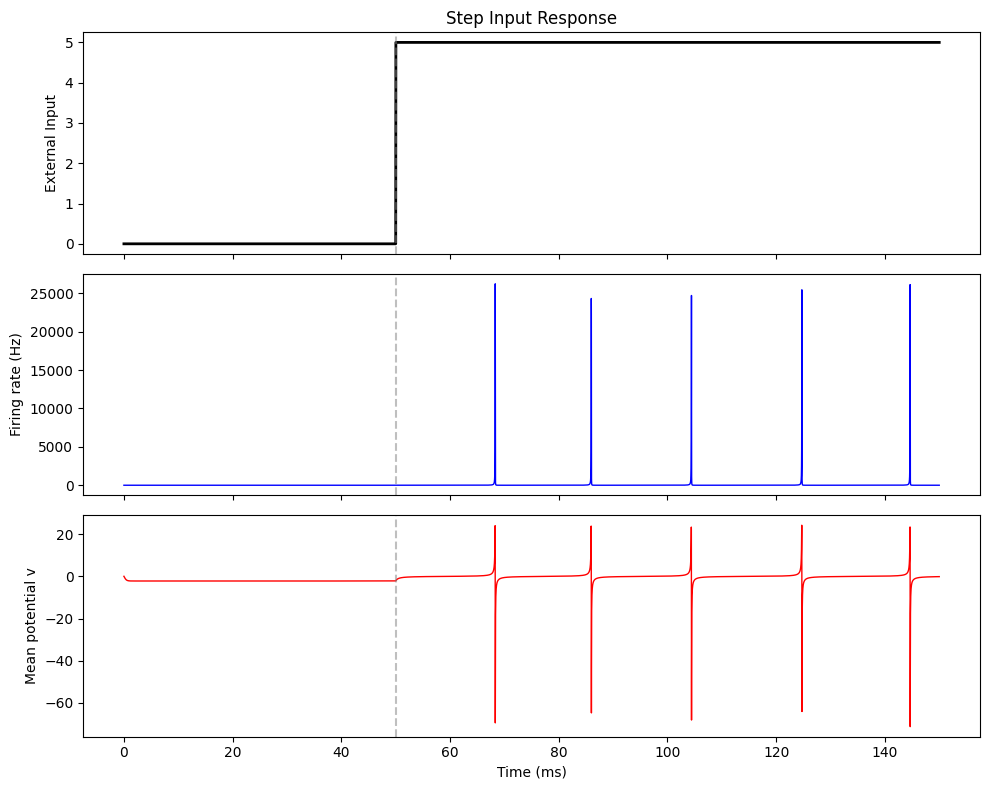

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# External input
input_trace = [get_input(t) for t in t_ms]
axes[0].plot(t_ms, input_trace, 'k-', linewidth=2)
axes[0].set_ylabel('External Input')
axes[0].set_title('Step Input Response')
axes[0].axvline(50, color='gray', linestyle='--', alpha=0.5)

# Firing rate
axes[1].plot(t_ms, r_trace[:, 0], 'b-', linewidth=1)
axes[1].set_ylabel('Firing rate (Hz)')
axes[1].axvline(50, color='gray', linestyle='--', alpha=0.5)

# Mean potential
axes[2].plot(t_ms, v_trace[:, 0], 'r-', linewidth=1)
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Mean potential v')
axes[2].axvline(50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Step 5: Bifurcation Analysis

Let's explore how the steady-state firing rate depends on mean excitability $\bar{\eta}$:

In [9]:
# Sweep eta values
eta_values = np.linspace(-10, 5, 50)
steady_r = []
steady_v = []

for eta_val in eta_values:
    model = brainmass.MontbrioPazoRoxinStep(
        in_size=1,
        tau=1.0 * u.ms,
        eta=eta_val,
        delta=1.0 * u.Hz,
        J=15.0,
    )
    brainstate.nn.init_all_states(model)
    model.r.value = np.array([0.1]) * u.Hz
    model.v.value = np.array([-1.0])


    # Run to steady state
    def step(i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            model.update()
            return model.r.value, model.v.value


    r, v = brainstate.transform.for_loop(step, np.arange(int(100 * u.ms / brainstate.environ.get_dt())))

    # Take final value (steady state)
    steady_r.append(float(r[-1, 0] / u.Hz))
    steady_v.append(v[-1, 0])

steady_r = np.array(steady_r)
steady_v = np.array(steady_v)

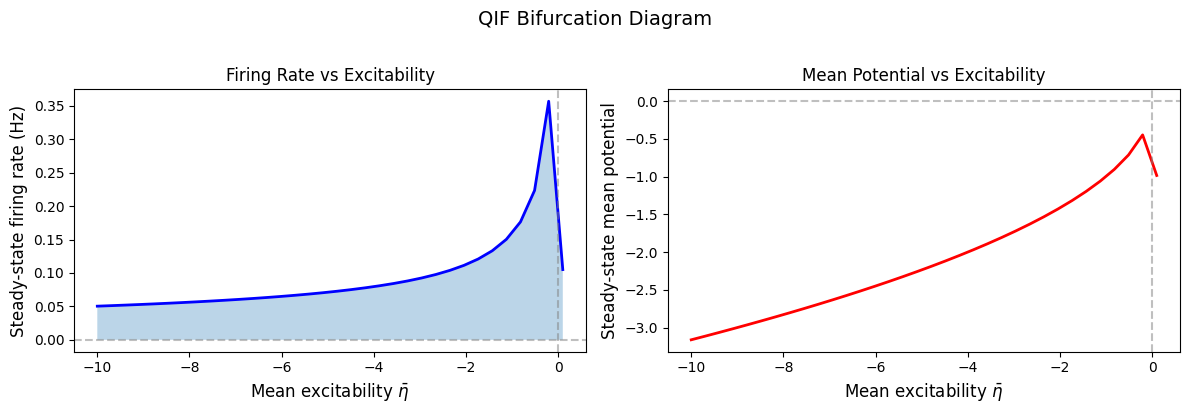

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# r vs eta
axes[0].plot(eta_values, steady_r, 'b-', linewidth=2)
axes[0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel(r'Mean excitability $\bar{\eta}$', fontsize=12)
axes[0].set_ylabel('Steady-state firing rate (Hz)', fontsize=12)
axes[0].set_title('Firing Rate vs Excitability')
axes[0].fill_between(eta_values, 0, steady_r, alpha=0.3)

# v vs eta
axes[1].plot(eta_values, steady_v, 'r-', linewidth=2)
axes[1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[1].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel(r'Mean excitability $\bar{\eta}$', fontsize=12)
axes[1].set_ylabel('Steady-state mean potential', fontsize=12)
axes[1].set_title('Mean Potential vs Excitability')

plt.suptitle('QIF Bifurcation Diagram', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

### Step 6: Effect of Heterogeneity ($\Delta$)

The parameter $\Delta$ controls population heterogeneity - how diverse the neurons are:

<>:29: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
C:\Users\adadu\AppData\Local\Temp\ipykernel_34064\219533765.py:29: SyntaxWarning: invalid escape sequence '\D'
  axes[idx].set_title(f'$\Delta$ = {delta_val} Hz')


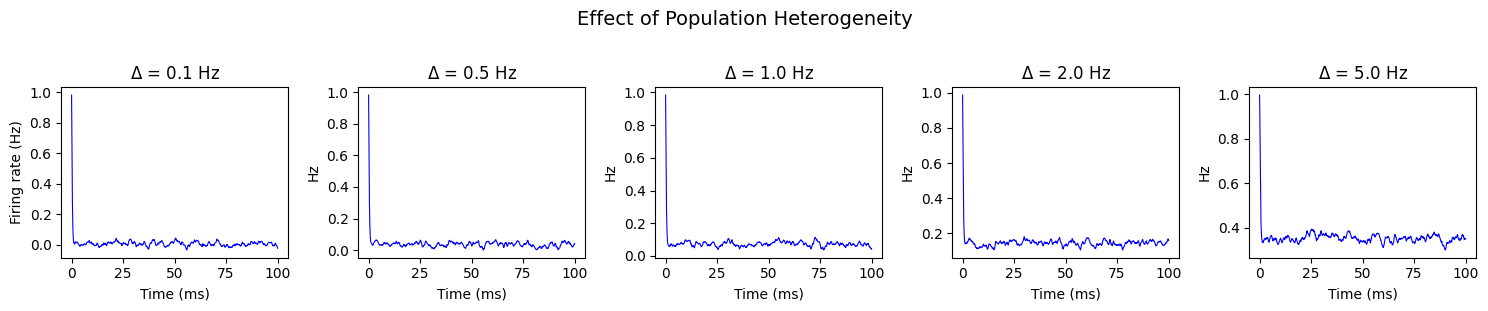

In [11]:
delta_values = [0.1, 0.5, 1.0, 2.0, 5.0]

fig, axes = plt.subplots(1, len(delta_values), figsize=(15, 3))

for idx, delta_val in enumerate(delta_values):
    model = brainmass.MontbrioPazoRoxinStep(
        in_size=1,
        tau=1.0 * u.ms,
        eta=-5.0,
        delta=delta_val * u.Hz,
        J=15.0,
        noise_r=brainmass.OUProcess(1, sigma=0.1 * u.Hz, tau=1.0 * u.ms),
    )
    brainstate.nn.init_all_states(model)
    model.r.value = np.array([1.0]) * u.Hz
    model.v.value = np.array([-1.0])


    def step(i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            model.update()
            return model.r.value


    r = brainstate.transform.for_loop(step, np.arange(int(100 * u.ms / brainstate.environ.get_dt())))
    t = np.arange(len(r)) * brainstate.environ.get_dt()

    axes[idx].plot(t, r[:, 0], 'b-', linewidth=0.8)
    axes[idx].set_title(f'$\Delta$ = {delta_val} Hz')
    axes[idx].set_xlabel('Time (ms)')
    if idx == 0:
        axes[idx].set_ylabel('Firing rate (Hz)')

plt.suptitle('Effect of Population Heterogeneity', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## Exercises

### Exercise 1: Oscillatory Regime

The QIF model can exhibit oscillations under certain parameter regimes. Try:

```python
model = brainmass.MontbrioPazoRoxinStep(
    in_size=1,
    tau=1.0 * u.ms,
    eta=5.0,     # Increase eta
    delta=0.5 * u.Hz,  # Reduce heterogeneity
    J=20.0,      # Strong coupling
)
```

Questions:
1. Can you find oscillatory dynamics?
2. What parameter combinations lead to oscillations?

### Exercise 2: Multiple Populations

Create E and I populations:

```python
# Excitatory population
E = brainmass.MontbrioPazoRoxinStep(1, eta=-3.0, J=15.0)
# Inhibitory population  
I = brainmass.MontbrioPazoRoxinStep(1, eta=-3.0, J=10.0)
```

Couple them and observe E-I dynamics.

### Exercise 3: Lorentzian Distribution

Visualize the Lorentzian distribution of excitabilities:

```python
def lorentzian(eta, eta_bar, delta):
    return delta / (np.pi * ((eta - eta_bar)**2 + delta**2))
```

How does $\Delta$ affect the distribution shape?

## Summary

In this tutorial, you learned:

1. **QIF mean-field model**: An exact reduction of spiking neuron populations
2. **Lorentzian heterogeneity**: The $\Delta$ parameter captures neuron diversity
3. **Two state variables**: Population rate $r$ and mean potential $v$
4. **Bifurcation behavior**: Transition from low to high firing states

### Key Insights

- **Exact reduction**: Unlike phenomenological models, QIF is mathematically exact
- **Heterogeneity matters**: $\Delta$ captures realistic neuronal diversity
- **Computational efficiency**: 2 ODEs vs thousands of spiking neurons

### Comparison with Other Models

| Model | Type | Basis | Heterogeneity |
|-------|------|-------|---------------|
| Wilson-Cowan | Phenomenological | Firing rate | None |
| Jansen-Rit | Phenomenological | PSP | None |
| QIF | Exact mean-field | Spiking neurons | Lorentzian |

### Next Steps

- **Tutorial 030**: Kuramoto model for phase synchronization
- **Tutorial 040**: Coupling mechanisms between populations
- **Tutorial 070**: Whole-brain modeling with mean-field nodes

## References

1. Montbrio, E., Pazo, D., & Roxin, A. (2015). Macroscopic description for networks of spiking neurons. *Physical Review X*, 5(2), 021028.

2. Gast, R., Schmidt, H., & Knosche, T. R. (2020). A mean-field description of bursting dynamics in spiking neural networks with short-term adaptation. *Neural Computation*, 32(9), 1615-1634.

3. Coombes, S., & Byrne, A. (2019). Next generation neural mass models. *Lecture Notes in Nonlinear Dynamics in Computational Neuroscience*.